In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import lusee
import os
import fitsio
import healpy as hp
import scipy.linalg as la
from scipy.ndimage import gaussian_filter
import matplotlib
import matplotlib.pyplot as plt

In [57]:
class PDRAnalysis:
    
    def __init__ (self, root, rmax=90, fsmooth=2.5):
        self.root = os.path.join(os.environ['LUSEE_DRIVE_DIR'],"Simulations/PDR",root)
        self.fsmooth = fsmooth
        self._load_data(rmax)      

    def smooth (self,v):
            return gaussian_filter(v,(20,self.fsmooth))

    def smooth1 (self,v):
            return gaussian_filter(v,self.fsmooth)

    def _load_data (self,rmax):
        dataA = []
        dataXR = []
        dataXI = []
        dataLR = []
        dataLI = []
        
        for R in range(10,rmax+1,10):
            fname = self.root+f"_R{R}.fits"
            print (f"Loading {fname}...")
            D = lusee.data.LData(fname)
            smooth = self.smooth
            dataA.append(smooth(D[:,'00RV',:]))
            dataA.append(smooth(D[:,'11RV',:]))
            dataA.append(smooth(D[:,'22RV',:]))
            dataA.append(smooth(D[:,'33RV',:]))
            dataXR.append(smooth(D[:,'02RV',:]))
            dataXR.append(smooth(D[:,'13RV',:]))
            dataXI.append(smooth(D[:,'02IV',:]))
            dataXI.append(smooth(D[:,'13IV',:]))
            dataLR.append(smooth(D[:,'01RV',:]))
            dataLR.append(smooth(D[:,'12RV',:]))
            dataLR.append(smooth(D[:,'23RV',:]))
            dataLR.append(smooth(D[:,'03RV',:]))
            dataLI.append(smooth(D[:,'01IV',:]))
            dataLI.append(smooth(D[:,'12IV',:]))
            dataLI.append(smooth(D[:,'23IV',:]))
            dataLI.append(-smooth(D[:,'03IV',:])) # conj(30)
        self.T2V2 = D.T2Vsq[0]
        self.dataA = np.vstack(dataA)
        self.dataXR = np.vstack(dataXR)
        self.dataXI = np.vstack(dataXI)
        self.dataLR = np.vstack(dataLR)
        self.dataLI = np.vstack(dataLI)

        fname = self.root+"_CMB.fits"
        if not os.path.isfile(fname):
            fname = self.root+"_R10_CMB.fits"
        print (f"Loading {fname}...")
        D=lusee.data.LData(fname)
        self.CMBA = self.smooth1(D[0,'00RV',:])
        self.CMBXR = self.smooth1(D[0,'02RV',:])
        self.CMBXI = self.smooth1(D[0,'02IV',:])
        self.CMBC = [self.CMBA,self.CMBXR]
        self.CMBLR = self.smooth1(D[0,'01RV',:])
        self.CMBLI = self.smooth1(D[0,'01IV',:])
        fname = self.root+"_14MHz_DA.fits" 
        if not os.path.isfile(fname):
            fname = self.root+"_R10_14MHz_DA.fits"
        print (f"Loading {fname}...")
        D=lusee.data.LData(fname)
        self.freq = D.freq
        self.DAA = self.smooth1(D[0,'00RV',:])
        #print ((D[0,'00RV',:]-D[-1,'11RV',:])/D[0,'00RV',:])
        self.DAXR = self.smooth1(D[0,'02RV',:])
        self.DALR = self.smooth1(D[0,'01RV',:])
        return 
    
    def get_sig_A(self,A=0.04,nu_min=16.4, nu_rms=14.):
        return self.CMBA*lusee.monosky.T_DarkAges_Scaled(self.freq,nu_min=nu_min, nu_rms=nu_rms,A=A)/2.73

    def get_CMB_A(self,A=2.73):
        return self.CMBA*A/2.73

    
    
    def get_sig_X(self,A=0.04,nu_min=16.4, nu_rms=14.):
        return self.CMBXR*lusee.monosky.T_DarkAges_Scaled(self.freq,nu_min=nu_min, nu_rms=nu_rms,A=A)/2.73
 
    def get_sig_C(self,A=0.04,nu_min=16.4, nu_rms=14.):
        return [self.get_sig_A(A,nu_min, nu_rms), self.get_sig_X(A,nu_min, nu_rms)]
    
    def set_analyzers(self,el=4e-9, ncycles = 18, errmult = 1, ones=True):
        ## cross are two times better, but have two times fewer antennas
        err =(self.dataA.mean(axis=0)+el**2)/np.sqrt(ncycles*14*24*3600*1e6)/np.sqrt(4) # for 4 antennas, 1e6 for 1MHz
        err *=errmult
        if ones:
            wA, wX = np.ones_like(self.freq), np.ones_like(self.freq)
        else:
            wA = 1/self.dataA.mean(axis=0)
            wX = 1/self.dataXR.mean(axis=0)
        self.AA = lusee.PCA_Analyzer(self.dataA,err,wA)
        self.AX = lusee.PCA_Analyzer(self.dataXR,err,wX)
        self.AC = lusee.Composite_PCA_Analyzer([self.AA,self.AX])
        return
    
    def make_gal_snr_plot(self):
        matplotlib.rcParams.update({'font.size': 18})
        fig = plt.figure(figsize=(14,10), constrained_layout=True)
        spec = fig.add_gridspec(ncols=2, nrows=2)

        ax1= fig.add_subplot(spec[0:, 0])
        ax2 = fig.add_subplot(spec[0, 1])
        ax3 = fig.add_subplot(spec[1, 1])

        f = self.freq
        xpow = 1e-21*3e8**2/(f*1e6)**2/1.380649e-23
        inst_noise = (4e-9)**2*np.ones_like(f)
        intg_noise = (inst_noise+self.dataA.mean(axis=0))/np.sqrt(48e3*1) #48kHz*1s
        
        ax1.plot (f,self.CMBA*lusee.monosky.T_NB(f)/2.73, color='b',label='Novaco - Brown 1978')
        ax1.plot (f,self.dataA.mean(axis=0),'g-',lw=2, label='Real Part (min/mean/max)')
        ax1.plot ([],[],'y-',lw=2, label='Imag Part (min/mean/max)')
        ax1.fill_between (f,self.dataA.min(axis=0), self.dataA.max(axis=0), color='g', alpha=0.2)
        ax1.plot(f,xpow*self.CMBA/2.73, '--',color='gray',lw=2,label='$10^{-21}$ W/m$^2$/Hz/sr')
        ax1.plot(f,inst_noise,ls=':', lw=2,color='gray',label= 'Instant. noise power')
        ax1.plot(f,intg_noise, ls='-', lw=2,color='gray',label='1 sec, 48kHz integr. noise')
        ax1.set_xlim(f[0],f[-1])
        ax1.semilogy()
        ax1.legend(fontsize=11, loc='lower right')
        ax1.set_title('Monopole auto-correlation',fontsize=16,  x=0.03, y=1, pad=-30,loc='left')

        shit = xpow/10/(self.dataA.mean(axis=0)+16e-18)
        print (shit.min(), shit.max(), shit.mean())
        

        ax2.yaxis.set_label_position("right")
        ax2.yaxis.tick_right()   
        ax2.plot (f,self.dataXR.mean(axis=0),'g-', label='mean',lw=2)
        ax2.fill_between (f,self.dataXR.min(axis=0), self.dataXR.max(axis=0), color='g', alpha=0.2,label='min/max')
        ax2.plot (f,self.CMBXR*lusee.monosky.T_NB(f)/2.73, color='b',label='Novaco - Brown 1978')    
        #ax2.plot (f,self.CMBXI*lusee.monosky.T_NB(f)/2.73, color='b',label='Novaco - Brown 1978')    
        ax2.plot (f,self.dataXI.mean(axis=0),'y-', label='mean',lw=2)
        ax2.fill_between (f,self.dataXI.min(axis=0), self.dataXI.max(axis=0), color='y', alpha=0.2,label='min/max')
        ax2.plot(f,inst_noise/2,ls=':', color='gray', lw=2)
        ax2.plot(f,-inst_noise/2, ls=':', color='gray', lw=2,)
        ax2.plot(f,xpow*self.CMBXR/2.73, '--',color='gray',lw=2,label='$10^{-21}$ W/m$^2$/Hz')
        ax2.plot(f,-xpow*self.CMBXR/2.73, '--',color='gray',lw=2,label='$10^{-21}$ W/m$^2$/Hz')
        ax2.plot(f,intg_noise, ls='-', color='gray', lw=2,label='inst. noise power')
        ax2.plot(f,-intg_noise, ls='-', color='gray', lw=2,)
        ax2.set_xlim(f[0],f[-1])
        ax2.set_title('Opposite cross-correlation',fontsize=14,  x=0.03, y=1, pad=-30,loc='left')

        
        

        ax3.yaxis.set_label_position("right")
        ax3.yaxis.tick_right()   
        ax3.plot (f,self.CMBLR*lusee.monosky.T_NB(f)/2.73, color='b',label='Novaco - Brown 1978')    
        ax3.plot (f,self.dataLR.mean(axis=0),'g-', label='Real part (min/mean/max)',lw=2)
        ax3.fill_between (f,self.dataLR.min(axis=0), self.dataLR.max(axis=0), color='g', alpha=0.2)
        #ax3.plot (f,self.CMBLI*lusee.monosky.T_NB(f)/2.73, color='b',label='Novaco - Brown 1978')    
        ax3.plot (f,self.dataLI.mean(axis=0),'y-', label='Imag part (min/mean/max)',lw=2)
        ax3.fill_between (f,self.dataLI.min(axis=0), self.dataXI.max(axis=0), color='y', alpha=0.2)
        #ax3.axline([0,16e-18/2/220],slope=0, ls=':', color='k', lw=2,label='inst. noise power')
        #ax3.axline([0,-16e-18/2/220],slope=0, ls=':', color='k', lw=2,label='inst. noise power')
        ax3.set_xlim(f[0],f[-1])
        ax3.plot(f,inst_noise/2, ls=':', color='gray', lw=2,label='Instant. noise power')
        ax3.plot(f,-inst_noise/2, ls=':', color='gray', lw=2,)
        ax3.plot(f,xpow*self.CMBLR/2.73, '--',color='gray',lw=2,label='$10^{-21}$ W/m$^2$/Hz')
        ax3.plot(f,-xpow*self.CMBLR/2.73, '--',color='gray',lw=2,label='$10^{-21}$ W/m$^2$/Hz')        
        ax3.plot(f,+intg_noise,ls='-', color='gray', lw=2)
        ax3.plot(f,-intg_noise, ls='-', color='gray', lw=2,)
        ax3.set_title('L cross-correlation',fontsize=14, x=0.03, y=1, pad=-30,loc='left')
        
        
        

        for ax in [ax1,ax2,ax3]:
            ax.set_xlabel('freq [MHz]')
            ax.set_ylabel('power [V$^2$/Hz]')

        SNRA = (self.dataA.mean(axis=0)**2/(16e-18)**2 * 1).sum()
        SNRX = (self.dataXR.mean(axis=0)**2/(0.5*16e-18)**2 * 1).sum()        
        SNRL = (self.dataLR.mean(axis=0)**2/(0.5*16e-18)**2 * 1).sum()        
             
        return np.sqrt(SNRA),np.sqrt(SNRX),np.sqrt(SNRL)
        
                  
    
    def make_snr_plot(self, rms_min=3,rms_max=16, pos_min=10, pos_max=40, ana='C', style=1):
        matplotlib.rcParams.update({'font.size': 22})
        plt.figure(figsize=(14,9))
        rms_list = np.linspace (rms_min,rms_max,100)
        pos_list = np.linspace(pos_min,pos_max,100)
        dpos = pos_list[1]-pos_list[0]
        if ana=='C':
            SNR = self.AC.SNR
            sig = self.get_sig_C
        elif ana=='A':
            SNR = self.AA.SNR
            sig = self.get_sig_A
        elif ana=='X':
            SNR = self.AX.SNR
            sig = self.get_sig_X

        if style == 1:
            tmin  = [[100/SNR(sig(A=1,nu_min=a,nu_rms=b))for a in pos_list] for b in rms_list] 
            tmin = np.array(tmin)
            from matplotlib.colors import LogNorm
            plt.imshow(gaussian_filter(tmin,(2,2)), extent=(10,40,3,16), origin='lower',norm=LogNorm(),aspect='auto')
            plt.plot(16.4,14,'rx')
            plt.xlabel('position')
            plt.ylabel('rms')
            plt.colorbar()
        elif style == 2:
            plt.plot(pos_list, lusee.monosky.T_NB(pos_list), 'k-', lw=3, label='Novaco - Brown 1978')
            plt.plot(pos_list, 0.2*lusee.monosky.T_NB(pos_list), 'k--', lw=3, label='Current-limits')
            plt.plot(pos_list, 1e-3*lusee.monosky.T_NB(pos_list), 'k:', lw=3, label='Science Goal')
            for i, rms in enumerate([16,12,8,4,2]):
                color = (i/4,0,1-i/4) 
                res = [50/SNR(sig(A=1,nu_min=a,nu_rms=rms))for a in pos_list]
                plt.plot(pos_list, gaussian_filter(res,3/dpos), lw=2,label=f"width = {rms} MHz", color=color)
            plt.plot(16.4,0.04,'*',markersize=14, color=(0.5/4,0,1-0.5/4), label='Dark Ages Expected')
            plt.semilogy()
            plt.xlabel('freq [MHz]')
            plt.ylabel('T [K]')
            plt.xlim(pos_list[0],pos_list[-1])
            plt.legend(loc='upper right',fontsize=14,framealpha=1)
            plt.grid()
        return 100/SNR(sig(A=1)),100/SNR(sig(A=1,nu_min=30, nu_rms=3.))
    
    def make_eigen_plot(self):
        plt.figure(figsize=(12,8))
        x=np.arange(1,51)
        matplotlib.rcParams['lines.linewidth'] = 2
        plt.plot(x,self.AA.eva0, label='Foreground')
        plt.plot(x,self.AA.eva, label='Foregrounds + noise')
        plt.plot(x,self.AA.get_template_power(self.get_sig_A(A=200)),label = 'Dark Ages A=200K')
        plt.plot(x,self.AA.get_template_power(self.get_CMB_A(A=200)),label = 'Uniform Radiation A=200K')
        plt.xlabel('Eigenvalue number')
        plt.ylabel('variance')
        plt.legend(fontsize=16)
        plt.semilogy()

In [58]:
rootlist = "hfss_lbl_2m_75deg hfss_lbl_2p5m_75deg hfss_lbl_3m_75deg hfss_lbl_2p7mAntennaHeight_1p5mLanderHeight hfss_lbl_3p2mAntennaHeight_2p0mLanderHeight_Baseline hfss_lbl_3p7mAntennaHeight_2p5mLanderHeight hfss_lbl_4p2mAntennaHeight_3p0mLanderHeight hfss_lbl_4p7mAntennaHeight_2p0mLanderHeight_2mLanderThickness hfss_lbl_4p7mAntennaHeight_3p5mLanderHeight hfss_lbl_5p2mAntennaHeight_4p0mLanderHeight hfss_lbl_5p7mAntennaHeight_4p5mLanderHeight".split()
#ootlist = rootlist[:3]
f = open ('figs.tex','w')
f.write("""
\\documentclass[a4paper,landscape]{article}
\\usepackage{geometry}
\\geometry{margin=0in}
\\usepackage[pdftex]{graphicx}
\\begin{document}
""")
for root in rootlist[:0]:
    A = PDRAnalysis(root,90)    
    SNR1,SNR2,SNR3=A.make_gal_snr_plot()
    
    plt.savefig('figures/gal_'+root+".pdf")
    plt.close()
    A.set_analyzers()
    SNR4,SNR5=A.make_snr_plot(style=2)
    plt.savefig('figures/sens_'+root+".pdf")
    plt.close()
    A.make_eigen_plot()
    plt.savefig('figures/eigen_'+root+".pdf")
    SNRT = np.sqrt(SNR1**2+SNR2**2+SNR3**2)
    plt.close()
    f.write("""
    \\newpage
    \\section*{"""+root.replace("_","\\_")+"""} 
    \n
    
    \\begin{tabular}{|c|c|c|c||c|c|}
    \\hline
    SNR Auto & SNR cross &  SNR L-shape & SNR total &  Dark Ages minT & Dark Ages 30+-3MHz minT \\\\
    \\hline
    """)
    f.write(f"{SNR1:.1f} & {SNR2:.1f} & {SNR3:.1f} &{SNRT:.1f} & {SNR4:.1f}K & {SNR5:.1f}K \\\\ \n")
    f.write("""
    \\hline
    \\end{tabular}
    
    \\
    
    """)
    f.write("\\includegraphics[width=14cm]{figures/gal_"+root+".pdf} \\\\ \n")  
    f.write("\\includegraphics[width=12cm]{figures/sens_"+root+".pdf}\n")    
    f.write("\\includegraphics[width=12cm]{figures/eigen_"+root+".pdf}\n")
    

f.write("\\end{document}")
f.close()
    
    

Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R10.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R20.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R30.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R40.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R50.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R60.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R70.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R80.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R90.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R10_CMB.fits...
Loading /home/anze/work/lusee/Drive/Simulations/PDR/hfss_lbl_3m_75deg_R10_14MHz_DA.fits...
5.973634357723887e+18 2.43495678341742e+22 8.12808033783382e+20


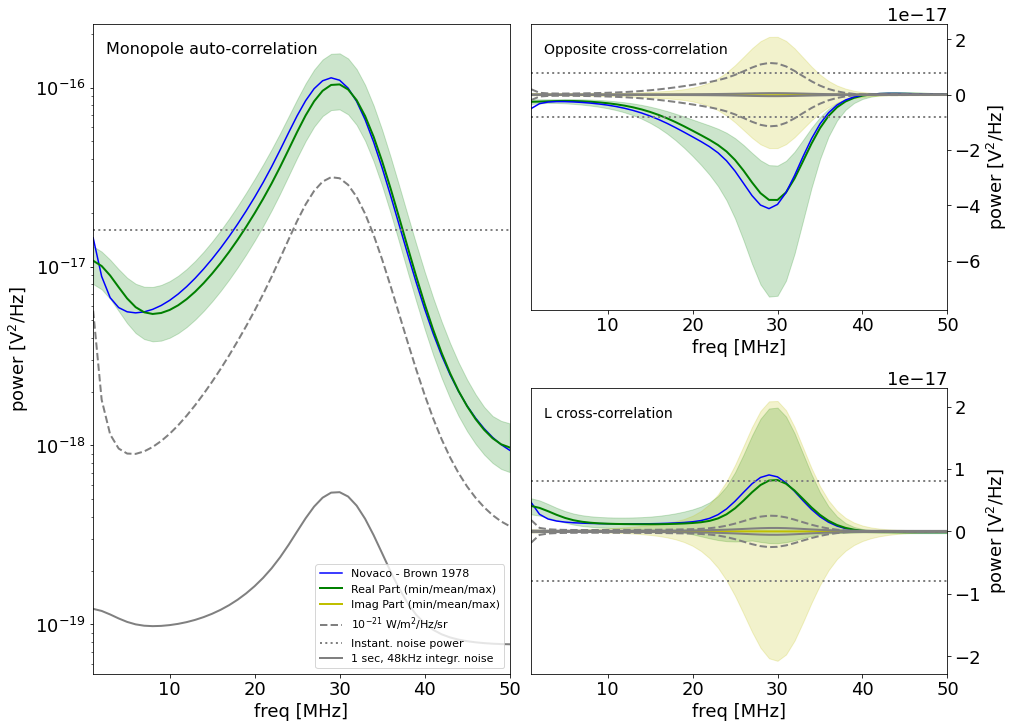

In [60]:
A3 = PDRAnalysis("hfss_lbl_3m_75deg",90)
A3.set_analyzers()
A3.make_gal_snr_plot()
plt.savefig('figures/gal_sens2.pdf')
#plt.close()   
    

In [ ]:
A3.make_eigen_plot()
plt.title('A3')

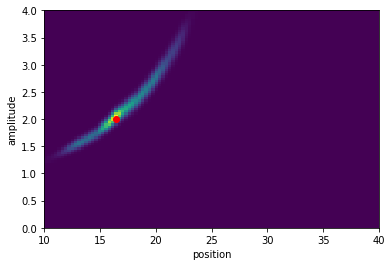

In [107]:
plt.imshow(np.exp(-chi2/10),interpolation='nearest',origin='lower', extent=[10,40,0,4],aspect='auto')
plt.xlabel('position')
plt.ylabel('amplitude')
plt.plot(16.4,2,'ro')

In [19]:
chi2.min()

64.67522500920509

In [20]:
trueA=2
truerms=14
truepos=16.4
A_list = np.linspace(0,4,100)

d = AC23.sim_data(get_sig_AX_23(trueA,nu_min=truepos,nu_rms=truerms))
chi2 = np.array([[AC23.get_chi2(get_sig_AX_23(A,nu_min=pos,nu_rms=truerms),d) 
                  for pos in pos_list]
                  for A in A_list])

chi2.min()

151.02906478246314

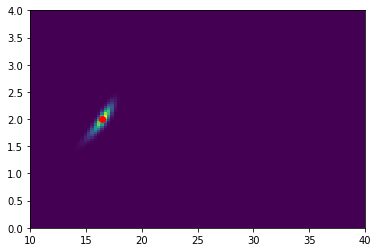

In [21]:
plt.imshow(np.exp(-chi2/10),interpolation='nearest',origin='lower', extent=[10,40,0,4],aspect='auto')
plt.plot(16.4,2,'ro')

[]

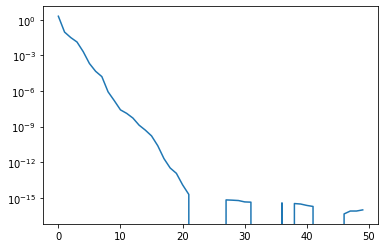

In [26]:
dA = np.vstack([get_data_A(SX) for SX in SR3])
err =(dA.mean(axis=0)+4e-9**2)/np.sqrt(16*14*24*3600*1e6)/np.sqrt(4)
ax=1/dA.mean(axis=0)
C=np.cov(dA*ax,rowvar=False)
eva,eve = la.eig(C)
plt.plot(eva)
plt.semilogy()

[]

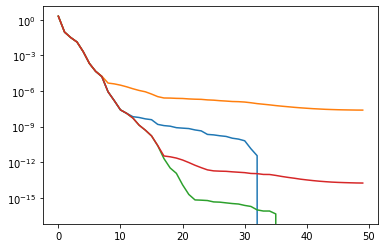

In [71]:
#dAr=dA.reshape((-1,dA.shape[0]//(12*59),dA.shape[1])).mean(axis=0)
err1 = err*np.sqrt(len(dA))
noise = np.random.normal(0,1,dA.shape)*err1[None,:]
Cn = np.cov((dA+noise)*ax,rowvar=False)-np.diag((err1*ax)**2)+np.diag((err*ax)**2)
evan,even = la.eig(Cn)
plt.plot(sorted(evan)[::-1])
Cn = np.cov((dA+noise)*ax,rowvar=False)
evan,even = la.eig(Cn)
plt.plot(sorted(evan)[::-1])
Cn2 = C+np.diag((err*ax)**2)
evan2,even2 = la.eig(Cn2)
plt.plot(sorted(eva)[::-1])
plt.plot(sorted(evan2)[::-1])
plt.semilogy()

In [50]:
dAr.shape

(116643, 50)

In [ ]:

# ATIC

def get_analyzer23(SR2,SR3):
    A2 = get_analyzer(SR2, errmult=np.sqrt(2))
    A3 = get_analyzer(SR3, errmult=np.sqrt(2))
    return lusee.Composite_PCA_Analyzer(A2.alist+A3.alist)